In [1]:
import numpy as np
import matplotlib.pyplot as plt
from local.lib import timeseries as ts
import pandas as pd
%matplotlib inline

# Create data and prepare time series dataset

In [2]:
idx = pd.date_range("2018-01-01", "2018-03-31", freq="6h")
i = np.linspace(-5,4,len(idx))
t = np.log(i**2+.1)*np.cos(4*i)
t += (np.random.normal(size=len(idx))*.6)**2
t = t*5+3
d = pd.DataFrame(np.r_[[t]].T, 
                 columns=["signal"], index=idx) 
d.head()


,signal
2018-01-01 00:00:00,15.089086
2018-01-01 06:00:00,13.081033
2018-01-01 12:00:00,12.345840
2018-01-01 18:00:00,13.818719
2018-01-02 00:00:00,14.723393


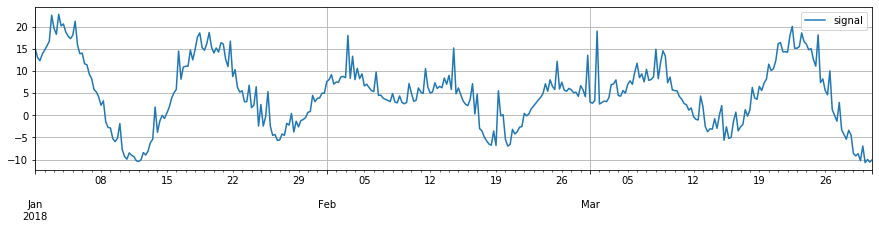

In [3]:
d.plot(figsize=(15,3)); plt.grid();

In [4]:
dt = ts.timeseries_as_many2one(d, columns=["signal"], nb_timesteps_in=4, timelag=0)
dt.head()

,signal_0,signal_1,signal_2,signal_3,signal
2018-01-02 00:00:00,15.089086,13.081033,12.345840,13.818719,14.723393
2018-01-02 06:00:00,13.081033,12.345840,13.818719,14.723393,15.693236
2018-01-02 12:00:00,12.345840,13.818719,14.723393,15.693236,16.762362
2018-01-02 18:00:00,13.818719,14.723393,15.693236,16.762362,22.646722
2018-01-03 00:00:00,14.723393,15.693236,16.762362,22.646722,19.677227


# Split train and test

(353, 5) (180, 5) (173, 5)


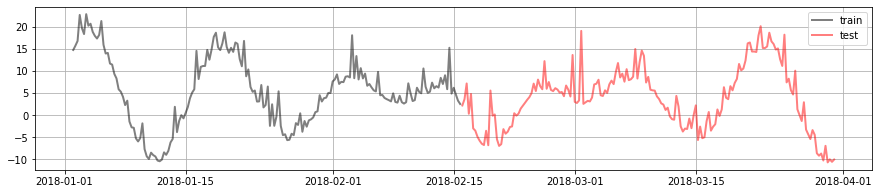

In [5]:
trds = dt[:"2018-02-15"]
tsds = dt["2018-02-16":]
print (dt.shape, trds.shape, tsds.shape)
plt.figure(figsize=(15,3))
plt.plot(trds.index.values, trds.signal.values, color="black", lw=2, label="train", alpha=.5)
plt.plot(tsds.index.values, tsds.signal.values, color="red", lw=2, label="test", alpha=.5)
plt.grid();
plt.legend();

# Solve as a linear regression task using `sklearn`

In [6]:
Xtr, ytr = trds[[i for i in trds.columns if i!="signal"]].values, trds.signal.values
Xts, yts = tsds[[i for i in tsds.columns if i!="signal"]].values, tsds.signal.values

In [7]:
from sklearn.linear_model import LinearRegression

In [8]:
lr = LinearRegression()
lr.fit(Xtr, ytr)
print (lr.intercept_, lr.coef_)

0.18643816668100577 [-0.11989891  0.12054291  0.4719835   0.4799619 ]


# Solve as a linear regresison task with custom loss function and optimization

In [9]:
from scipy.optimize import minimize

def rlinear_prediction(t, X):
    return t[0] + X.dot(t[1:])

def J(t, x, y, prediction):
    return np.mean( (prediction(t,x)-y)**2)

r1 = minimize(lambda t: J(t, Xtr, ytr, rlinear_prediction), np.random.random(size=Xtr.shape[1]+1))
r1

      fun: 6.932937022761894
 hess_inv: array([[ 0.78898989, -0.01895304, -0.0114633 , -0.00834696, -0.01174405],
       [-0.01895304,  0.0707237 , -0.03345326, -0.02999617, -0.00490758],
       [-0.0114633 , -0.03345326,  0.0863365 , -0.02136543, -0.02991146],
       [-0.00834696, -0.02999617, -0.02136543,  0.08648283, -0.03326487],
       [-0.01174405, -0.00490758, -0.02991146, -0.03326487,  0.07110973]])
      jac: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.78813934e-07])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 7
     njev: 12
   status: 0
  success: True
        x: array([ 0.18643825, -0.11989891,  0.12054291,  0.4719835 ,  0.47996189])

observe model params are the same in both cases

In [10]:
print ("sklearn LR params", lr.intercept_, lr.coef_)
print ("custom LR params ", r1.x[0], r1.x[1:])

sklearn LR params 0.18643816668100577 [-0.11989891  0.12054291  0.4719835   0.4799619 ]
custom LR params  0.18643824643641188 [-0.11989891  0.12054291  0.4719835   0.47996189]


### inspect predictions

In [11]:
trpredr = rlinear_prediction(r1.x, Xtr)
tspredr = rlinear_prediction(r1.x, Xts)

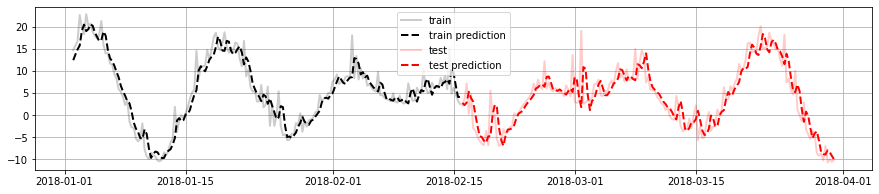

In [12]:
plt.figure(figsize=(15,3))
plt.plot(trds.index.values, trds.signal.values, color="black", lw=2, label="train", alpha=.2)
plt.plot(trds.index.values, trpredr, color="black", ls="--", lw=2, label="train prediction", alpha=1)
plt.plot(tsds.index.values, tsds.signal.values, color="red", lw=2, label="test", alpha=.2)
plt.plot(tsds.index.values, tspredr, color="red", ls="--", lw=2, label="test prediction", alpha=1)
plt.grid();
plt.legend();

### would this prediction be profitable when used in a trading strategy?

if predicted price is greater than current value, then first buy then sell. if lower do the opposite.

In [13]:
def rpnl(X,y,pred):
    return np.sum(((pred>X[:,-1]).astype(int)-.5)*2*(y-X[:,-1]))

def cpnl(X,y,pred):
    return np.sum((pred-.5)*2*(y-X[:,-1]))

def raccuracy(X,y,pred):
    return np.mean((y>X[:,-1])==(pred>X[:,1]))


In [14]:
rtrain_pnl = rpnl(Xtr,ytr,trpredr)
rtest_pnl = rpnl(Xts,yts,tspredr)
print ("PNL in train %6.2f"%rtrain_pnl)
print ("PNL in test  %6.2f"%rtest_pnl)


PNL in train 173.51
PNL in test  150.53


In [15]:
print ("trend prediction accuracy in train %6.2f"%raccuracy(Xtr,ytr,trpredr))
print ("trend prediction accuracy in test  %6.2f"%raccuracy(Xts,yts,tspredr))


trend prediction accuracy in train   0.53
trend prediction accuracy in test    0.53


# Solve as a classification problem

how much accuracy would we obtain if we predict trend (insted of price) and design a classification problem (instead of regression)?

first we convert the target variable for a classification task

In [16]:
ytrc = (ytr>Xtr[:,-1]).astype(int)
ytsc = (yts>Xts[:,-1]).astype(int)
ytsc

array([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1])

check class distribution

In [17]:
print ("ONEs in train %.2f"%np.mean(ytrc))
print ("ONEs in test  %.2f"%np.mean(ytsc))


ONEs in train 0.50
ONEs in test  0.50


# Solve with `sklearn`

In [18]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(Xtr, ytrc)
trpredc = lr.predict(Xtr)
tspredc = lr.predict(Xts)

In [23]:
ctrain_pnl = cpnl(Xtr,ytr,trpredc)
ctest_pnl = cpnl(Xts,yts,tspredc)

print ("PNL in train %6.2f"%cpnl(Xtr,ytr,trpredc))
print ("PNL in test  %6.2f"%cpnl(Xts,yts,tspredc))

print ("acc in train %6.2f"%np.mean(ytrc==trpredc))
print ("acc in test  %6.2f"%np.mean(ytsc==tspredc))


PNL in train 193.13
PNL in test  124.23
acc in train   0.66
acc in test    0.62


## Solve with custom loss function

In [24]:
from scipy.optimize import minimize

sigm = lambda x: 1/(1+np.exp(-x))

def clinear_prediction(t, X):
    return sigm(.1*(t[0] + X.dot(t[1:])))

In [25]:
def J(t, X, y, prediction):
    return np.mean( (prediction(t,X)-y)**2)
    
r1 = minimize(lambda t: J(t, Xtr, ytrc, clinear_prediction), np.random.random(size=Xtr.shape[1]+1))

tspredo = ((clinear_prediction(r1.x, Xts))>.5).astype(int)
trpredo = ((clinear_prediction(r1.x, Xtr))>.5).astype(int)

print ("PNL in train %6.2f"%cpnl(Xtr,ytr,trpredo))
print ("PNL in test  %6.2f"%cpnl(Xts,yts,tspredo))

print ("acc in train %6.2f"%np.mean(ytrc==trpredo))
print ("acc in test  %6.2f"%np.mean(ytsc==tspredo))


PNL in train 189.06
PNL in test  145.00
acc in train   0.64
acc in test    0.64


In [26]:
np.mean(ytsc)

0.49710982658959535

# Solve with bussiness focused custom loss function

after some research and experimentation we define the following loss function:


$$J(t;X,y) = \text{mean} \Bigg[\text{abs}(dy) \cdot \Big(\tanh\big(k\cdot d\hat{y}\big) - \tanh\big(k \cdot dy\big)\Big)^2\Bigg]$$

with:

- $dy = y-X_{[:,-1]}$, the difference between the next price and current price
- $d\hat{y}= \hat{y}-X_{[:,-1]}$, the difference between the predicted price and current price
- $k \in (0.01,1)$

and:

- $y$ the true price
- $\hat{y}$ the predicted price
- $X_{[:,-1]}$ the last item of the input vector: use in Python `X[:,-1]`

observe that the squared term tries to account for both prediction and target having the same sign:

- it has a small value when both $dy$ and $d\hat{y}$ have the same sign
- it is larger when the sign is different

and, finally, the $abs(dy)$ term tries to penalize predictions when the possible profit is large.

remember that we want to **minimize** $J$.

what is your interpretation on why this loss function works?

Text(0.5, 1.0, '$[\\tanh\\; d\\hat{y}  - \\tanh\\; dy]^2$')

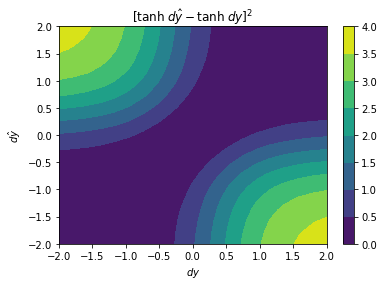

In [27]:
dy = np.linspace(-2,2,20)
dyh = np.linspace(-2,2,20)
yy,hh = np.meshgrid(dy,dyh)
z=(np.tanh(yy)-np.tanh(hh))**2
plt.contourf(yy,hh,z)
plt.colorbar()
plt.xlabel("$dy$"); plt.ylabel("$d\hat{y}$"); plt.title(r"$[\tanh\; d\hat{y}  - \tanh\; dy]^2$")

In [34]:
def J(t, X, y, prediction):
    yhat = prediction(t,X)

    # YOUR CODE HERE
    k = 0.1 # try with different values for k
    r = ...
    return r

r1 = minimize(lambda t: J(t, Xtr, ytr, rlinear_prediction), .1*np.random.random(size=Xtr.shape[1]+1))

tspredx = ((rlinear_prediction(r1.x, Xts))>Xts[:,-1]).astype(int)
trpredx = ((rlinear_prediction(r1.x, Xtr))>Xtr[:,-1]).astype(int)

print ("PNL in train %6.2f"%cpnl(Xtr,ytr,trpredx))
print ("PNL in test  %6.2f"%cpnl(Xts,yts,tspredx))

print ("acc in train %6.2f"%np.mean(ytrc==trpredx))
print ("acc in test  %6.2f"%np.mean(ytsc==tspredx))


PNL in train 227.05
PNL in test  162.45
acc in train   0.64
acc in test    0.62


observe the trend predictions in test

In [187]:
tspredx

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1])

observe the comparison of the prediction signals

- generated by plain linear regression
- generated by our custom loss function

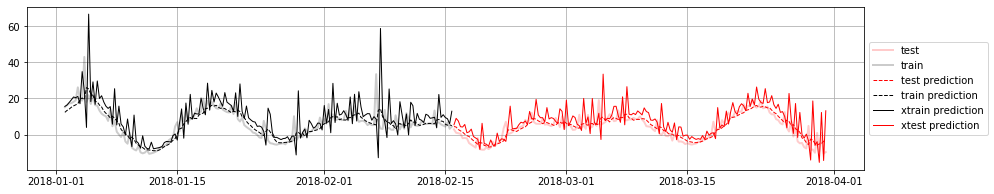

In [188]:
tspredxr = rlinear_prediction(r1.x, Xts)
trpredxr = rlinear_prediction(r1.x, Xtr)


plt.figure(figsize=(15,3))
plt.plot(tsds.index.values, tsds.signal.values, color="red", lw=2, label="test", alpha=.2)
plt.plot(trds.index.values, trds.signal.values, color="black", lw=2, label="train", alpha=.2)

plt.plot(tsds.index.values, tspredr, color="red", ls="--", lw=1, label="test prediction", alpha=1)
plt.plot(trds.index.values, trpredr, color="black", ls="--", lw=1, label="train prediction", alpha=1)

plt.plot(trds.index.values, trpredxr, color="black", ls="-", lw=1, label="xtrain prediction", alpha=1)
plt.plot(tsds.index.values, tspredxr, color="red", ls="-", lw=1, label="xtest prediction", alpha=1)

plt.grid();
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [29]:
#solution_code =  [10, 100, 101, 102, 32, 74, 40, 116, 44, 32, 88, 44, 32, 121, 44, 32, 112, 114, 101, 100, 105, 99, 116, 105, 111, 110, 41, 58, 10, 32, 32, 32, 32, 121, 104, 97, 116, 32, 61, 32, 112, 114, 101, 100, 105, 99, 116, 105, 111, 110, 40, 116, 44, 88, 41, 10, 10, 32, 32, 32, 32, 100, 121, 104, 97, 116, 32, 61, 32, 121, 104, 97, 116, 45, 88, 91, 58, 44, 45, 49, 93, 10, 32, 32, 32, 32, 100, 121, 32, 32, 32, 32, 61, 32, 121, 45, 88, 91, 58, 44, 45, 49, 93, 32, 32, 32, 32, 10, 32, 32, 32, 32, 107, 32, 61, 32, 48, 46, 50, 10, 32, 32, 32, 32, 114, 101, 116, 117, 114, 110, 32, 110, 112, 46, 109, 101, 97, 110, 40, 32, 110, 112, 46, 97, 98, 115, 40, 100, 121, 41, 42, 40, 110, 112, 46, 116, 97, 110, 104, 40, 107, 42, 100, 121, 104, 97, 116, 41, 45, 110, 112, 46, 116, 97, 110, 104, 40, 107, 42, 100, 121, 41, 41, 42, 42, 50, 41, 10]
#print ("".join(["%c"%i for i in solution_code]))